In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1 Data Preprocessing
Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.



## Preprocessing Data Files:
training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.

test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels

submissionFileFormat.csv: list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what you need to predict. 


## 1.1 Import libraries

In [0]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, Dropout, Dense, Flatten, MaxPooling2D, BatchNormalization
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, CSVLogger, ModelCheckpoint, EarlyStopping, LearningRateScheduler

## 1.2 Import data files

In [11]:
Train_Dir = '/content/drive/My Drive/F19/CS 583 - Deep Learning/Assignments/final-project/data/training.csv'
Test_Dir = '/content/drive/My Drive/F19/CS 583 - Deep Learning/Assignments/final-project/data/test.csv'
lookid_dir = '/content/drive/My Drive/F19/CS 583 - Deep Learning/Assignments/final-project/data/IdLookupTable.csv'
train_data = pd.read_csv(Train_Dir)  
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)
os.listdir('/content/drive/My Drive/F19/CS 583 - Deep Learning/Assignments/final-project/data')

['.~lock.training.csv#',
 'IdLookupTable.csv',
 'SampleSubmission.csv',
 'test.csv',
 'training.csv']

## 1.3 Training Data

### 1.3.1 Look at the data
take a look at the data

In [12]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


### 1.3.2 Check for missing values




In [13]:
# on a per data point basis
train_data.T.isnull().any().value_counts()

True     4909
False    2140
dtype: int64

In [14]:
# on a per feature basis
train_data.isnull().any().value_counts()

True     28
False     3
dtype: int64

Out of 7049 images, 4909 has missing values.
Out of 30 features, 28 have missing values.

Options:
1. Eliminate rows with missing values
2. Fill missing values with average for that column

It's not viable either to remove 28 features or get rid if 4909 data points, as it would mean losing a lot of information. I choose to fill the missing values by placing the average for that feature.

Get the average of each feature:

In [0]:
# this takes the average of all features excluding the column that contains the image
# that column makes everything slow and its meaningless
feature_means = train_data.T[train_data.columns != "Image"].mean(axis=1, skipna=True)

In [0]:
feature_means_dict = feature_means.to_dict()

In [0]:
for label in feature_means_dict.keys():
    train_data[label].fillna(feature_means_dict[str(label)], inplace = True)

If everything ran smoothly, the means should remain the same (because adding the mean doesnt affect the mean) and there should be no columns with NaN

In [18]:
# how many features have NaNs?
print("\nAny columns have NaN values?", train_data.isnull().any().value_counts())
print("Any rows with NaN values?", train_data.T.isnull().any().value_counts())



Any columns have NaN values? False    31
dtype: int64
Any rows with NaN values? False    7049
dtype: int64


### 1.3.3 Separate the training features from the training labels
train_x = the image pixel values

train_y = the locations of the keypoints

In [0]:
train_x = []

for image_idx in range(0,7049):
    img = train_data['Image'][image_idx].split(' ')
    img = ['0' if x == '' else x for x in img]
    train_x.append(img)

In [0]:
train_x = np.array(train_x, dtype = 'float32')
train_x = train_x.reshape(-1, 9216)

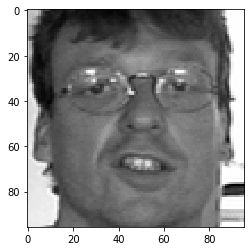

In [21]:
plt.imshow(train_x[1000].reshape(96,96), cmap='gray')

Now that the train_x data is cleaned up and ready, lets take care of the labels.

Currently, the labels are 15 features, represented by x and y coordinates, giving a total of 30 data fields.

At first, I will attempt to train by concatenating all features of each image into a 30-dimensional vector of floats.


In [22]:
# remove the 'Image' column, as that has been placed in train_x already, and we dont need it to occupy memory any longer
train_data = train_data.drop('Image', axis=1)

# ensure that 'Image' Column was removed correctly
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.244810
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.856170,59.412000,60.003339,58.565890
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.982380
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


Now, place all 7049 30-dim vector of labels into a numpy array

In [0]:
train_y = [] 
for img_idx in range(0,7049):
  y = train_data.iloc[img_idx, :] 
  train_y.append(y)

train_y = np.array(train_y, dtype='float32')

Randomize the training data:

In [0]:
n = train_x.shape[0]

rand_indices = np.random.permutation(n)
train_indices = rand_indices[0:n]


In [0]:
train_x = train_x[train_indices]
train_y = train_y[train_indices]

## 1.4 Test Data

### 1.4.1 Prepare test data

Just like I placed the "Image" column values into a numpy array of arrays in the training data, I'll do the same with the test data.

### 1.4.2 Look at the test data
How many data points are there in the test set?
How is the test data formatted?

In [26]:
print(test_data.shape)
test_data.head()

(1783, 2)


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [0]:
test_x = []

for img_idx in range(0, 1783):
  img = test_data['Image'][img_idx].split(' ')
  img = ['0' if x == '' else x for x in img]

  test_x.append(img)

In [0]:
# cast the data into a numpy array
test_x = np.array(test_x, dtype='float32')
test_x = test_x.reshape(-1, 9216)

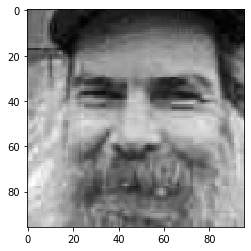

In [29]:
# show an image to ensure reshaping and casting went well
plt.imshow(test_x[1782].reshape(96,96), cmap='gray')

### 1.4.3 Understand the submission format




As part of the data, I was given a sample submission. Lets explore that file.

In [0]:
sample_submission_dir = '/content/drive/My Drive/F19/CS 583 - Deep Learning/Assignments/final-project/data/SampleSubmission.csv'
submission_data = pd.read_csv(sample_submission_dir)  

In [31]:
submission_data.head()

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


Looks like there is just two columns, and 27124 rows. There is only a `rowId` to identify each row. 

Lets look at the fourth file we were given, the `IdLookupTable.csv` and get some clues as to how this submission is wanted:

In [121]:
lookid_data.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


Each row in the submission file has a rowID. We can use the `IdLookupTable.csv` file to find which Image and which predicted feature belong to each rowID. 

## 1.5 Summary of Data Preprocessing

During this first section, I got to understand **how data is provided** to me, and what are the setbacks of the data that will make training harder.

I found out that the data had lots of holes, with **missing information** on 4909 out of the 7049 images, almost 70% of my data points were incomplete!

I opted for a solution that will take the average of the value for that feature among all datapoints.

Because the standard deviation of each feature is not so large, using the mean of the feature to fill out the missing holes is actually not a bad estimate.

For the test data, I formatted it the same way as the training data.

# 2 The Models

Since I only have 7049 examples, I want to avoid overfitting. In this section **I will try different models**. Note that I will name these models differently, and you can **skip the sections containing the "other" models, and run the last (best) model only**

## 2.1 Training a simple FC model

I'll start with a very simple sequential model with a single fully connected hidden layer. I will use this initial as a baseline to compare to.


In [0]:
def build_simple_model():
  """function that defines model with 2 hidden layers, and compiles it. 
  returns compiled model"""
  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(9216,)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(30))

  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  print(model.summary())
  return model


In [123]:
simple_model = build_simple_model()

simple_model_history = simple_model.fit(train_x, train_y, batch_size=32,
                           epochs=500, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 30)                1950      
Total params: 1,189,982
Trainable params: 1,189,982
Non-trainable params: 0
_________________________________________________________________
None
Train on 5639 samples, validate on 1410 samples
Epoch 1/500
5639/5639 [==============================] - 9s 2ms/step - loss: 36458.1775 - mean_absolute_error: 97.5580 - val_loss: 2612.5063 - val_mean_absolute_error: 47.6231
Epoch 2/500
5639/5639 [==============================] - 1s 196us/step - loss: 2613.4327 - mean_absolute_error: 47.6220 - val_loss: 2595.7062 - v

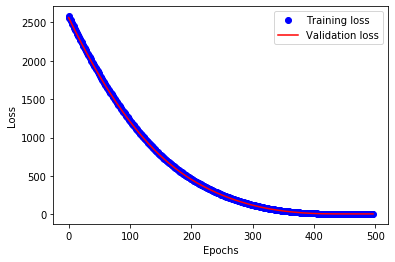

In [124]:
loss = simple_model_history.history['loss'][3:]
val_loss = simple_model_history.history['val_loss'][3:]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

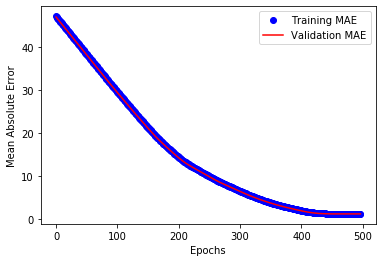

In [125]:
mae = simple_model_history.history['mean_absolute_error'][3:]
val_mae = simple_model_history.history['val_mean_absolute_error'][3:]

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

**Performance of Simple Model**

The simple model does not overfit on the validation data even after training reaches a plateau. 
I will assume that plateau is just due to ***reaching the learning capacity of this simple model***.

I will confirm my suspicion by increasing the model capacity, and seeing if (with proper regularization) I can reach lower errors.


### 2.1.2 Testing Simple model

Now its time to prepare my first submission to the competition, and see how far down the leaderboard I get.

![hoping for the best](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQhp_4JhuO7JvxzZPOQQ5m_HrvVF-ltjCaktAxEQoimCEQe6kDO&s)


### 2.1.3 Predict on the test data

In [0]:
pred = simple_model.predict(test_x)

### 2.1.4 Create submission file

In [0]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)

In [0]:
rowid = list(lookid_data['RowId'])

In [0]:
feature = []

for f in lookid_list:
    feature.append(lookid_list.index(f))

In [0]:
preded = []

for x,y in zip(imageID, feature):
    preded.append(pre_list[x][y])

In [0]:
rowid = pd.Series(rowid, name = 'RowId')
loc = pd.Series(preded, name='Location')

In [0]:
submission = pd.concat([rowid, loc], axis=1)

In [0]:
submission.to_csv('submission_simple_model.csv', index=False)

### 2.1.5 Results of Simple Model

The simple 2 layer fully connected network achieves a Root Mean Squared Error of 3.96 on the competition. This is ranking 141 out of 175 competitors. 

I consider this a bad result, and judging by the plots of training and validation loss, the model does not overfit at all during training, even without any regularization.

My next step will be to increase the complexity of the Fully Connected model, and regularize when appropriate.


## 2.2 Training a Medium Complexity Model

This time around, I'll be adding more layers to the FC model, and I will add regularization as I see appropriate from observing the behavior of the model during training.

In [0]:
def build_mid_model():
    """function that defines model with 6 hidden layers, and compiles it. 
    returns compiled model"""
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(9216,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(30))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    print(model.summary())
    return model


In [135]:
mid_model = build_mid_model()

mid_model_history = mid_model.fit(train_x, train_y, batch_size=32,
                           epochs=300, validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               2359552   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_34 (Dense)             (None, 64)               

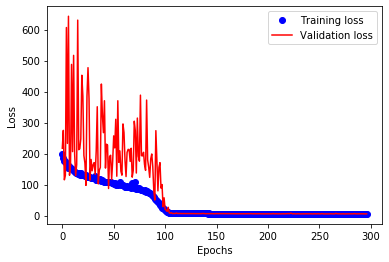

In [136]:
loss = mid_model_history.history['loss'][3:]
val_loss = mid_model_history.history['val_loss'][3:]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

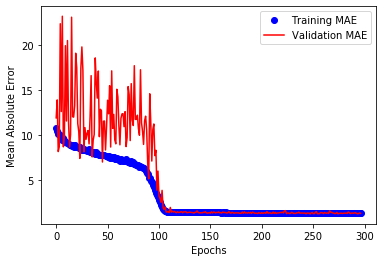

In [137]:
mae = mid_model_history.history['mean_absolute_error'][3:]
val_mae = mid_model_history.history['val_mean_absolute_error'][3:]

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

### 2.2.2 Testing Medium Complexity FC model

Now its time to prepare my first second submission to the competition, and see if there is any improvement from the Simple Model.






### 2.2.3 Predict on the test data

In [0]:
pred = mid_model.predict(test_x)

### 2.2.4 Create submission file

In [0]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)

In [0]:
rowid = list(lookid_data['RowId'])

In [0]:
feature = []

for f in lookid_list:
    feature.append(lookid_list.index(f))

In [0]:
preded = []

for x,y in zip(imageID, feature):
    preded.append(pre_list[x][y])

In [0]:
rowid = pd.Series(rowid, name = 'RowId')
loc = pd.Series(preded, name='Location')

In [0]:
submission = pd.concat([rowid, loc], axis=1)

In [0]:
submission.to_csv('submission_mid_model.csv', index=False)

### 2.2.5 Results of Medium FC Model

The medium complexity 7 layer fully connected network achieves a Root Mean Squared Error of 3.65 on the competition. This is ranking 99 out of 175 competitors. 

This is definitely a better result than the simple model, which ranked 141/175 in the competition. Judging by the plots of training and validation loss, the model does not overfit at all during training, especially with the little regularization.

My next step will be to increase the complexity of the Fully Connected model even more, and regularize when appropriate.


## 2.3 Training a Large FC Model

This time around, I'll be adding even more layers to the FC model, and I will add regularization as I see appropriate from observing the behavior of the model during training.

If this does not improve my performance significantly, I will attempt a convolutional neural network.


In [0]:
def build_large_model():
    """function that defines model with 12 hidden layers, and compiles it. 
    returns compiled model"""
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(9216,))) #1
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu')) #2
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #3
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #4
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #5
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #6
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #7
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #8
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #9
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #10
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #11
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #12
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #13
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu')) #14
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu')) #15
    model.add(Dense(64, activation='relu')) #16
    model.add(Dense(30))

    rmsprop = optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=rmsprop, loss='mse', metrics=['mae'])
    print(model.summary())
    return model


In [33]:
large_model = build_large_model()

large_model_history = large_model.fit(train_x, train_y, batch_size=32,
                           epochs=300, validation_split=0.2)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2359552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         


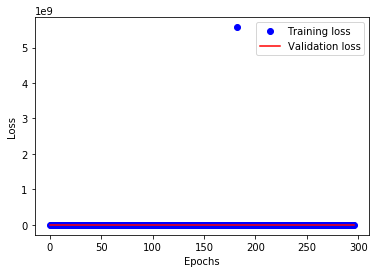

In [34]:
loss = large_model_history.history['loss'][3:]
val_loss = large_model_history.history['val_loss'][3:]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

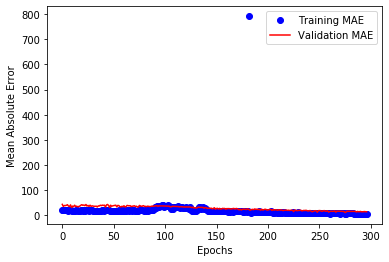

In [35]:
mae = large_model_history.history['mean_absolute_error'][3:]
val_mae = large_model_history.history['val_mean_absolute_error'][3:]

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

### 2.3.1 Results of Large FC Model

I attemped several different "deeper" FC models. Some with a large 512 node layer at the beginning, and some with at most 128 node layers. I tried gradually decreasing the size of the layers, or keeping them the same, etc.

During training the validation loss was oscillating, and not decresing. Model was overfitting even with lots of regularization. I concluded that an FC model is not the best solution to this problem.
Given that this is a vision problem, I will attempt a Convolutional Neural Network to solve it. 




In [0]:
submission.to_csv('submission_mid_model.csv', index=False)

## 2.4 Training a Convolutional Neural Network

After the big failure of the "deeper" fully connected layer for this problem, I felt like I should do some reading.
I found a [research paper ](https://arxiv.org/pdf/1710.00977.pdf) in arxiv.org that helped me get an idea of a possible good starting point for a CNN.

Let's see how the CNN does!

In [0]:
train_x_cnn = train_x.reshape(7049,96,96,1)

In [0]:
def build_cnn_model():
    """function that defines convolutional neural network model, and compiles it. 
    returns compiled model"""
    model = Sequential()

    model.add(Conv2D(32, (4,4), input_shape=(96,96,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (2,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(30))

    adamopt = optimizers.Adam()
    
    model.compile(optimizer=adamopt, loss='mse', metrics=['mae'])
    print(model.summary())
    return model


In [41]:
cnn_model = build_cnn_model()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                               cooldown=0, patience=6, min_lr=0.5e-6, verbose=1)

cnn_model_history = cnn_model.fit(train_x_cnn, train_y, batch_size=64,
                           epochs=50, validation_split=0.2,
                           callbacks=[lr_reducer])



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 93, 93, 32)        544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 93, 93, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 93, 93, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 64)     

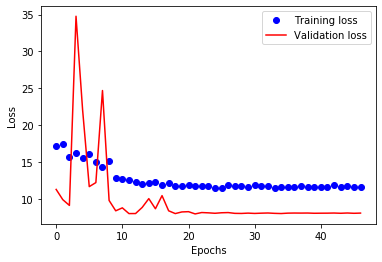

In [42]:
loss = cnn_model_history.history['loss'][3:]
val_loss = cnn_model_history.history['val_loss'][3:]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

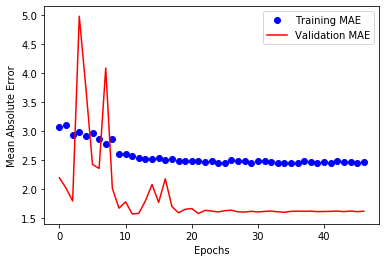

In [43]:
mae = cnn_model_history.history['mean_absolute_error'][3:]
val_mae = cnn_model_history.history['val_mean_absolute_error'][3:]

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

### 2.4.2 Testing ConvNet model

Now its time to prepare my third submission to the competition, and see if there is any improvement from the Fully Connected model.

<img src="http://m.quickmeme.com/img/c9/c9e377d277dd66bf7540a9e0302d68227f585312751d7e9e0b1dac0a509709fd.jpg" width="300"/>




### 2.4.3 Predict on the test data

In [0]:
test_x_cnn = test_x.reshape(1783, 96, 96, 1)

In [0]:
pred = cnn_model.predict(test_x_cnn)

### 2.4.4 Create submission file

In [0]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)

In [0]:
rowid = list(lookid_data['RowId'])

In [0]:
feature = []

for f in lookid_list:
    feature.append(lookid_list.index(f))

In [0]:
preded = []

for x,y in zip(imageID, feature):
    preded.append(pre_list[x][y])

In [0]:
rowid = pd.Series(rowid, name = 'RowId')
loc = pd.Series(preded, name='Location')

In [0]:
submission = pd.concat([rowid, loc], axis=1)

In [0]:
submission.to_csv('submission_cnn_model.csv', index=False)

### 2.4.5 Results of First CNN Model

This convolutional neural network achieves a RMSE of 3.35 on the competition, which is ranking 80/175. This is a nice improvement from the 6 layer FC which had achieved ranking 99/175.

Even though this CNN is definitely better than the FC model, I expected a much better result. For some reason the validation loss (RMSE_Val) is much lower (better) than the training loss, but my competition score agrees more with the training loss.

I also had to change the optimizer, because RMSprop was oscilating too much. 


My next step will be to continue to explore CNN designs, and optimizers.


## 2.5 Training an improved CNN

The previous CNN did better than the FC networks. Now its time to try adding some model complexity so we can drive the training loss down.

In [0]:
train_x_cnn = train_x.reshape(7049,96,96,1)

In [0]:
def build_cnn2_model():
    """function that defines convolutional neural network model, and compiles it. 
    returns compiled model"""
    model = Sequential()

    model.add(Conv2D(32, (4,4), input_shape=(96,96,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (2,2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (1,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))

    model.add(Dense(128, activation='relu'))

    model.add(Dense(30))

    adamopt = optimizers.Adam()
    
    model.compile(optimizer=adamopt, loss='mse', metrics=['mae'])
    print(model.summary())
    return model


In [46]:
cnn2_model = build_cnn2_model()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                               cooldown=0, patience=9, min_lr=0.5e-6, verbose=1)

cnn2_model_history = cnn2_model.fit(train_x_cnn, train_y, batch_size=64,
                           epochs=70, validation_split=0.2,
                           callbacks=[lr_reducer])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 93, 93, 32)        544       
_________________________________________________________________
batch_normalization_10 (Batc (None, 93, 93, 32)        128       
_________________________________________________________________
activation_10 (Activation)   (None, 93, 93, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
activation_11 (Activation)   (None, 44, 44, 64)       

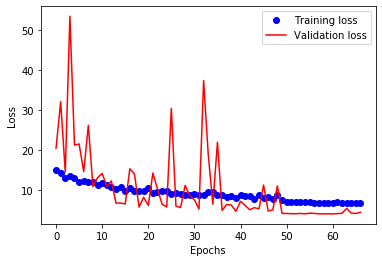

In [30]:
loss = cnn2_model_history.history['loss'][3:]
val_loss = cnn2_model_history.history['val_loss'][3:]

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

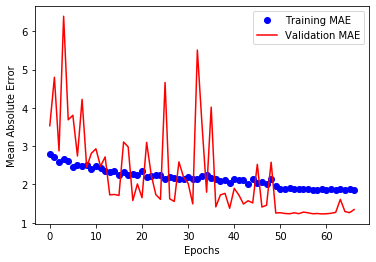

In [31]:
mae = cnn2_model_history.history['mean_absolute_error'][3:]
val_mae = cnn2_model_history.history['val_mean_absolute_error'][3:]

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

### 2.5.2 Testing ConvNet model

Now its time to prepare my third submission to the competition, and see if there is any improvement from the Fully Connected model.

<img src="http://m.quickmeme.com/img/e5/e5e9efb570b2ff99ec37323aded9534797fe25e39a25d3d583a599729c8a9b20.jpg" alt="let this be the last attempt" width="300"/>



### 2.5.3 Predict on the test data

In [0]:
test_x_cnn = test_x.reshape(1783, 96, 96, 1)

In [0]:
pred = cnn2_model.predict(test_x_cnn)

### 2.5.4 Create submission file

In [0]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)

In [0]:
rowid = list(lookid_data['RowId'])

In [0]:
feature = []

for f in lookid_list:
    feature.append(lookid_list.index(f))

In [0]:
preded = []

for x,y in zip(imageID, feature):
    preded.append(pre_list[x][y])

In [0]:
rowid = pd.Series(rowid, name = 'RowId')
loc = pd.Series(preded, name='Location')

In [0]:
submission = pd.concat([rowid, loc], axis=1)

In [0]:
submission.to_csv('submission_cnn3_model.csv', index=False)

### 2.5.5 Results of Second CNN Model

This convolutional neural network achieves a RMSE of 2.89 on the competition, which is ranking 56/175. This is a really nice improvement from the previous CNN which had achieved ranking 80/175.

What changed between the previous CNN and this one?
One additional Conv2D layer of 64 (3,3) filters, and the replacement of the last Conv2D layer to have 256 (1,1) filters instead of 128 (1,1) filters.

